In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'computed-tomography-ct-of-the-brain:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3856259%2F6685411%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240813%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240813T090541Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D64441c25fe00dd61775cb932378abc58188f47c858b9aefca07a0e0ac3dba1fe2fc6f6ba9f3687aac7cbfdea9b94902c7708b1eb5085c7fcbeece4e117ae87e903c97e97e184aa87c5f9222009f1ba82ec3747d12a13e6a7c1ddaa400e70d74e46b83502a4c8282f5bfcac32a2655e51eba7232a7f3077d87b58c04817e306ad34ca53c0f5cfee04267305844ece20d649e5c7ed336f561053f43ad855d6cb9fbde50ebfe98c0f90385a03053ee262b40fbbdba34e4ce8d7097e8592f37ccf267b1a2a075dde0fb4002f388a249823da8021f5db651b71e0ca69f1ba767da74500bcbe5c9afe280a6e985b7187bc32e2e7217ef12bebcddd4a76948d652978e1'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 69191139 bytes downloaded
Downloaded and uncompressed: computed-tomography-ct-of-the-brain
Data source import complete.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import PIL as pl
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, AvgPool2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.layers import RandomBrightness, RandomFlip, RandomRotation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import os

import warnings
warnings.filterwarnings('ignore')

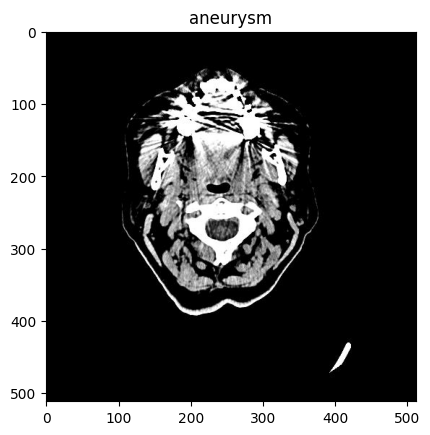

In [ ]:
img = cv2.imread('/kaggle/input/computed-tomography-ct-of-the-brain/files/aneurysm/0.jpg')
plt.title('aneurysm')
plt.imshow(img, label = 'aneurysm')

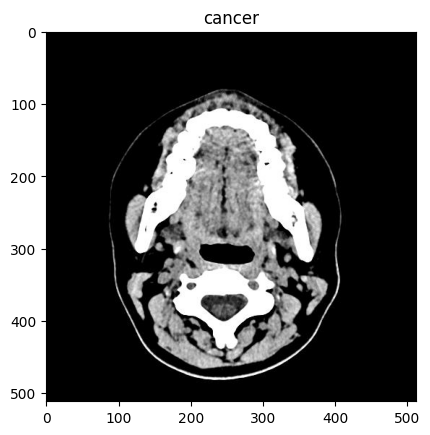

In [ ]:
img = cv2.imread('/kaggle/input/computed-tomography-ct-of-the-brain/files/cancer/0.jpg')
plt.title('cancer')
plt.imshow(img)

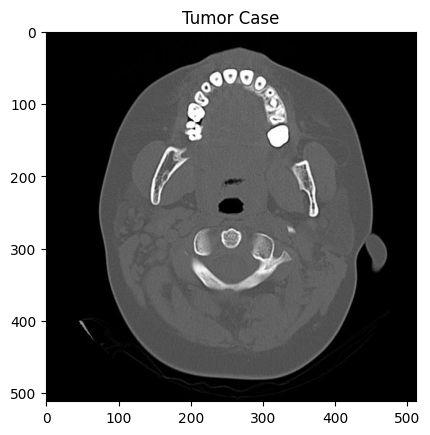

In [ ]:
img = cv2.imread('/kaggle/input/computed-tomography-ct-of-the-brain/files/tumor/0.jpg')
plt.title('Tumor Case')
plt.imshow(img)

In [ ]:
img.shape

(512, 512, 3)

In [ ]:
dir = '/kaggle/input/computed-tomography-ct-of-the-brain/files'
img_width = 224
img_height = 224

In [ ]:
train_data = image_dataset_from_directory(dir,label_mode = "categorical", image_size = (img_height, img_width),batch_size = 10, shuffle = True,seed = 12, validation_split = 0.3, subset = "training")
test_data = image_dataset_from_directory(dir,label_mode = "categorical", image_size = (img_height, img_width),batch_size = 10, shuffle = True,seed = 12, validation_split = 0.2, subset = "validation")
val_data = image_dataset_from_directory(dir,label_mode = "categorical", image_size = (img_height, img_width),batch_size = 10, shuffle = True,seed = 12, validation_split = 0.1, subset = "validation")

Found 259 files belonging to 3 classes.
Using 182 files for training.
Found 259 files belonging to 3 classes.
Using 51 files for validation.
Found 259 files belonging to 3 classes.
Using 25 files for validation.


## Data Augmentation

In [ ]:
augmentation = Sequential()

In [ ]:
augmentation.add(RandomBrightness(factor = 0.2))
augmentation.add(RandomFlip(mode = 'horizontal'))
augmentation.add(RandomRotation(factor = 0.2, fill_mode = 'nearest'))

In [ ]:
model = Sequential()

In [ ]:
# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

In [ ]:
# Freeze the base model layers
base_model.trainable = False

In [ ]:
# Create new model on top
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = augmentation(inputs)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(3, activation='softmax')(x)
model = Model(inputs, outputs)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience = 9, verbose = 1)

In [ ]:
checkpoint = ModelCheckpoint(filepath = '/kaggle/working/bests.keras', monitor = 'val_accuracy', mode = 'max', save_best_only = True, verbose = 1)

In [ ]:
history = model.fit(train_data, validation_data = val_data, epochs = 200, callbacks = [early_stopping, checkpoint])

Epoch 1/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5029 - loss: 4.5069
Epoch 1: val_accuracy improved from -inf to 0.88000, saving model to /kaggle/working/bests.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 138s 7s/step - accuracy: 0.5074 - loss: 4.4519 - val_accuracy: 0.8800 - val_loss: 0.3002
Epoch 2/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8737 - loss: 0.5552
Epoch 2: val_accuracy did not improve from 0.88000
19/19 ━━━━━━━━━━━━━━━━━━━━ 130s 7s/step - accuracy: 0.8748 - loss: 0.5548 - val_accuracy: 0.8800 - val_loss: 0.2839
Epoch 3/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9377 - loss: 0.1354
Epoch 3: val_accuracy did not improve from 0.88000
19/19 ━━━━━━━━━━━━━━━━━━━━ 149s 7s/step - accuracy: 0.9373 - loss: 0.1406 - val_accuracy: 0.8800 - val_loss: 0.2622
Epoch 4/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9591 - loss: 0.1746
Epoch 4: val_accuracy improved from 0.88000 to 1.00000, saving model to /kaggle/working/bests.keras
19/19 ━━━━━━━━━━━

##VGG16

In [ ]:
best_model = load_model('/kaggle/working/bests.keras')

In [ ]:
# Prepare data for additional metrics
y_true = []
y_pred = []
y_pred_proba = []

In [ ]:
for images, labels in test_data:
    y_true.extend(np.argmax(labels, axis=1))
    predictions = best_model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_pred_proba.extend(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step


In [ ]:
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)

In [ ]:
loss, acc = best_model.evaluate(test_data)

6/6 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - accuracy: 0.9761 - loss: 0.3252


In [ ]:
print(f'\nAccuracy = {acc}\nLoss = {loss}')


Accuracy = 0.9803921580314636
Loss = 0.2724913954734802


In [ ]:
# Calculate and print classification report (includes F1-score)
class_report = classification_report(y_true, y_pred, target_names=test_data.class_names, digits=10)
print("\nClassification Report:")
print(class_report)


Classification Report:
              precision    recall  f1-score   support

    aneurysm  1.0000000000 0.9090909091 0.9523809524        11
      cancer  1.0000000000 1.0000000000 1.0000000000        23
       tumor  0.9444444444 1.0000000000 0.9714285714        17

    accuracy                      0.9803921569        51
   macro avg  0.9814814815 0.9696969697 0.9746031746        51
weighted avg  0.9814814815 0.9803921569 0.9802054155        51



In [ ]:
# Calculate and print AUC (one-vs-rest)
auc_scores = []
for i in range(3):  # Assuming 3 classes
    auc = roc_auc_score((y_true == i).astype(int), y_pred_proba[:, i])
    auc_scores.append(auc)
    print(f"AUC for class {test_data.class_names[i]}: {auc:.4f}")

print(f"Average AUC: {np.mean(auc_scores):.4f}")

AUC for class aneurysm: 0.9591
AUC for class cancer: 1.0000
AUC for class tumor: 1.0000
Average AUC: 0.9864


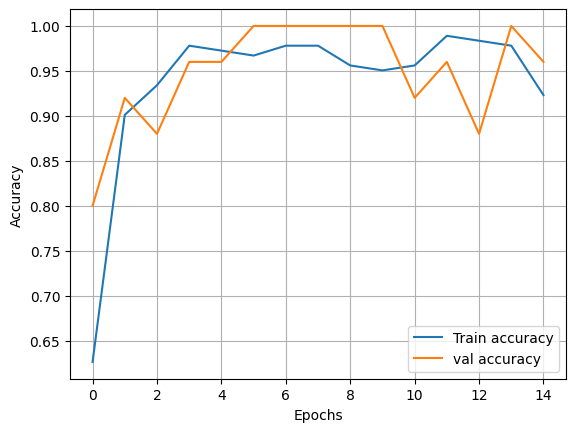

In [ ]:
plt.plot(history.history['accuracy'], label = 'Train accuracy')
plt.plot(history.history['val_accuracy'], label = 'val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = 'best')
plt.grid()

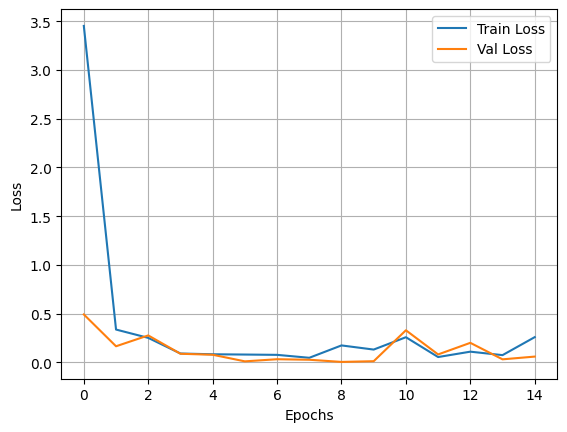

In [ ]:
plt.plot(history.history['loss'], label = 'Train Loss')
plt.plot(history.history['val_loss'], label = 'Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc = 'best')
plt.grid()

##VGG16+RF

In [ ]:
best_model = load_model('/kaggle/working/bests.keras')

In [ ]:
# Create feature extractor model
feature_extractor = Sequential([
    augmentation,
    base_model,
    GlobalAveragePooling2D()
])

In [ ]:
# Function to extract features and labels from a dataset
def extract_features(dataset):
    features = []
    labels = []
    for images, batch_labels in dataset:
        batch_features = feature_extractor.predict(images)
        features.append(batch_features)
        labels.append(batch_labels)
    return np.concatenate(features), np.concatenate(labels)

In [ ]:
# Extract features for train, validation, and test sets
X_train, y_train = extract_features(train_data)
X_val, y_val = extract_features(val_data)
X_test, y_test = extract_features(test_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [ ]:
# Convert one-hot encoded labels to class indices
y_train = np.argmax(y_train, axis=1)
y_val = np.argmax(y_val, axis=1)
y_test = np.argmax(y_test, axis=1)

In [ ]:
# Train Random Forest
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Evaluate Random Forest
y_pred = rf_classifier.predict(X_test)
y_pred_proba = rf_classifier.predict_proba(X_test)

In [ ]:
# Calculate and print classification report (includes F1-score)
class_report = classification_report(y_true, y_pred, target_names=test_data.class_names, digits=10)
print("\nClassification Report:")
print(class_report)


Classification Report:
              precision    recall  f1-score   support

    aneurysm  1.0000000000 0.8181818182 0.9000000000        11
      cancer  0.9583333333 1.0000000000 0.9787234043        23
       tumor  0.9444444444 1.0000000000 0.9714285714        17

    accuracy                      0.9607843137        51
   macro avg  0.9675925926 0.9393939394 0.9500506586        51
weighted avg  0.9626906318 0.9607843137 0.9593122355        51

